In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

Check CUDA installation

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


In [3]:
bitcoin = pd.read_csv('data/btc.csv')
bitcoin

,unix_timestamp,entry_date,symbol,open_price,high_price,low_price,close_price,coin_volume
0,1417411980,2014-12-01 06:33:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 06:40:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 07:24:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 07:50:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 06:29:00+01:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4911801,1722276180,2024-07-29 20:03:00+02:00,BTC-USD,67112.69,67240.21,67073.33,67231.12,16.786577
4911802,1722276240,2024-07-29 20:04:00+02:00,BTC-USD,67231.11,67270.14,67215.95,67232.61,14.302211
4911803,1722276300,2024-07-29 20:05:00+02:00,BTC-USD,67232.60,67266.29,67182.71,67255.35,12.772139
4911804,1722276360,2024-07-29 20:06:00+02:00,BTC-USD,67254.00,67290.65,67221.06,67256.28,16.879374


In [4]:
crypto_df = dict()
crypto_df['bitcoin'] = bitcoin

In [5]:
close_btc = crypto_df['bitcoin'].close_price


C:\Users\Doosheck\AppData\Local\Temp\ipykernel_24260\2182110235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['entry_date'] = pd.to_datetime(sampled_data['entry_date'], utc=True)


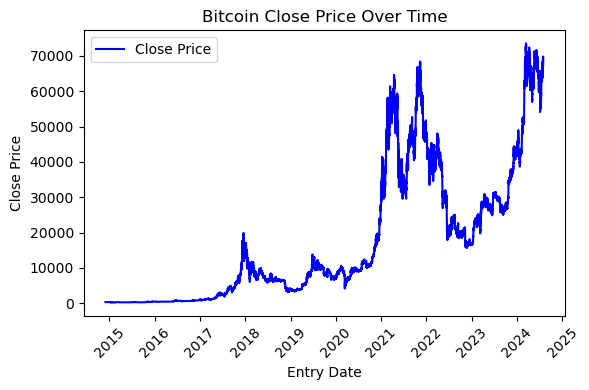

In [6]:
sampled_data = bitcoin.iloc[::100]

# Ensure 'entry_date' is a datetime object
sampled_data['entry_date'] = pd.to_datetime(sampled_data['entry_date'], utc=True)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(sampled_data['entry_date'], sampled_data['close_price'], label='Close Price', color='blue')
plt.xlabel('Entry Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
btc_prices = np.diff(bitcoin['close_price'])
btc_prices_csum = np.cumsum(btc_prices)

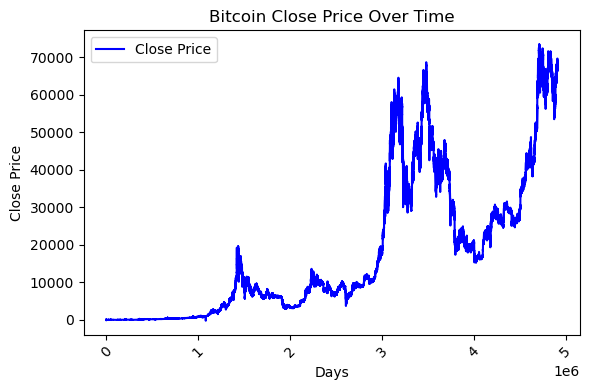

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(btc_prices_csum, label='Close Price', color='blue')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Net

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [10]:
input_window = 7
output_window = 1
batch_size = 128  # batch size

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)    # 0::2 means start from 0 and step 2
        pe[:, 1::2] = torch.cos(position * div_term)    # 1::2 means start from 1 and step 2
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, num_heads=10, hidden_size=128, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size, dropout)
        encoder_layers = TransformerEncoderLayer(feature_size, num_heads, hidden_size, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output
    
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.tril(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [30]:
def create_inout_sequences(input_data, input_window):
    sequences, labels = [], []
    L = len(input_data)
    for i in range(L-input_window):
        train_seq = input_data[i:i+input_window]
        train_label = input_data[i+input_window:i+input_window+1]
        sequences.append(train_seq)
        labels.append(train_label)
    return (torch.tensor(sequences, dtype=torch.float32), 
            torch.tensor(labels, dtype=torch.float32))

In [31]:
def get_data(data, split):
    split = round(split * len(data))
    train_data = data[:split]
    test_data = data[split:]

    train_data = train_data.cumsum()
    test_data = test_data.cumsum()

    train_sequence, train_labels = create_inout_sequences(train_data, input_window)
    test_sequence, test_labels = create_inout_sequences(test_data, input_window)

    return (train_sequence.to(device), train_labels.to(device)), \
           (test_sequence.to(device), test_labels.to(device))

In [32]:
train_data, test_data = get_data(btc_prices_csum, 0.8)

In [33]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    # data_input = torch.stack([item[0] for item in data]).float().to(device)
    # data_target = torch.stack([item[1] for item in data]).float().to(device)
    data_input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, dim=1)).to(device)
    data_target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, dim=1)).to(device)
    return data_input, data_target

In [45]:
model = TransformerModel().to(device)

criterion = nn.MSELoss() 
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 1500

c:\Users\Doosheck\miniconda3\envs\comp\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    src_mask = model._generate_square_subsequent_mask(input_window).to(device)
    
    # Ensure log_interval is at least 1
    log_interval = max(1, int(len(train_data) / batch_size / 5))

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        if data.size(0) != batch_size:
            src_mask = model._generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [36]:
def evaluate(model, data_source):
    model.eval()
    total_loss = 0.
    src_mask = model._generate_square_subsequent_mask(input_window).to(device)
    eval_batch_size = batch_size
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            if data.size(0) != batch_size:
                src_mask = model._generate_square_subsequent_mask(data.size(0)).to(device)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).item()
    return total_loss / len(data_source)

In [37]:
def predict(model, sequences):
    start_time = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    elapsed = time.time() - start_time
    print(f"Complete the prediction in {elapsed} seconds.")
    return predicted_seq, real_seq

RUN MODEL

In [46]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)
    if epoch % N_EPOCHS == 0:
        val_loss = evaluate(model, test_data)
        try:
            ppl = math.exp(val_loss)
        except OverflowError:
            ppl = float('inf')
        
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | valid ppl {:8.2f}'.format(
            epoch, (time.time() - epoch_start_time), val_loss, ppl))
        print('-' * 80)
    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(
            epoch, (time.time() - epoch_start_time)))
        print('-' * 80)
    
    scheduler.step()

--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.02s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   2 | time:  0.01s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   3 | time:  0.01s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   4 | time:  0.01s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   5 | time:  0.01s
--------------------------------------------------------------------------------
--------------------

In [43]:
predicted_seq, real_seq = predict(model, test_data)


Complete the prediction in 0.0060007572174072266 seconds.


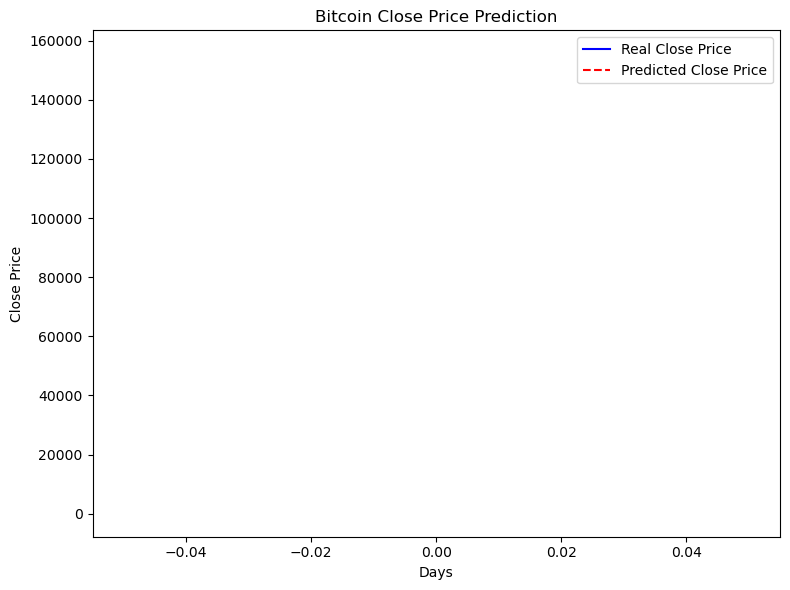

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(real_seq, label='Real Close Price', color='blue')
ax.plot(predicted_seq, label='Predicted Close Price', color='red', linestyle='--')
ax.set_xlabel('Days')
ax.set_ylabel('Close Price')
ax.set_title('Bitcoin Close Price Prediction')
ax.legend()
plt.tight_layout()
plt.show()